In [33]:
# Following code is implementation of simulation published in:
# "Brownian Dynamics Simulations of Rotational Diffusion Using
# the Cartesian Components of the Rotation Vector as Generalized Coordinates"
# T. R. Evensen, S. N. Naess & A. Elgsaeter
# Macromol. Theory Simul. (2008)
# doi:10.1002/mats.200800031

import pychastic
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

In [34]:
# Font parameters
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['mathtext.fontset'] = 'cm'

radius = 0.55e-6  # particle radius		[m]

rho_p = 2.0e3  # particle density		[kg/m^3]
rho_f = 997  # fluid density			[kg/m^3]

T = 300  # fluid temperature			[K]
kB = 1.38e-23  # Boltzmann constant		[J/K]
kBT = kB * T

g = 9.81  # gravitational acceleration	[m/s^2]
eps_0 = 8.854e-12  # vacuum permitivity	[F/m]
epsilon = 80 * eps_0  # water permitivity 	[F/m]
kappa = 1 / 103e-9  # 1 / Debye length	[1/m]
e = 1.602e-19  # elementary charge		[C]
eta = 1e-3  # dyn. viscosity of the fluid	[Pa*s]

zeta_w = -54e-3  # wall-corresp. zeta potential [V]
zeta_p = -30e-3  # par.-corresp. zeta potential [V]

# wall's Stern potential	[V]
psi_w = zeta_w / ((kappa * radius) / ((1.0 + kappa * radius) * jnp.e))
# particle's Stern potential	[V]
psi_p = zeta_p / ((kappa * radius) / ((1.0 + kappa * radius) * jnp.e))

In [35]:
def mobility(xq):
    H = xq[2] * 1e6
    unsafe_phi_squared = jnp.sum(xq[3:] ** 2)
    phi_squared = jnp.maximum(unsafe_phi_squared, jnp.array(0.001) ** 2)
    phi = jnp.sqrt(phi_squared)
    cos = 1.0 - (1.0 - jnp.cos(phi)) * (1.0 - (xq[5] / phi) ** 2)
    sin = jnp.sqrt(1.0 - cos ** 2)

    Xtt = 3.8708425598363618
    Ytt = 4.3479650066773061
    Xrr = 1.8030828271581760
    Yrr = 3.7400782411154063
    Xrd = -1.5710943251115512
    Xdr = 1.5710943251115512

    resistance_matrix = jnp.array([[Xtt-(Xtt**2*((-3*cos**2)/2-(3*(1-cos**2))/4))/(8*H)+(Xtt*(4*Xtt**2*((-3*cos**2)/2-(3*(1-cos**2))/4)**2+(9*Xtt*Ytt*cos**2*sin**2)/4))/(256*H**2),
	0,(-3*Xtt*Ytt*cos*sin)/(32*H)+(Ytt*(3*Xtt**2*cos*((-3*cos**2)/2-(3*(1-cos**2))/4)*sin+3*Xtt*Ytt*cos*sin*((-3*sin**2)/2-(3*(1-sin**2))/4)))/(256*H**2),
	0,(Xdr*Xtt*((-9*cos**2*sin)/2+3*(-sin/2+cos**2*sin)))/(32*H**2),0],
	[0,Ytt+(3*Ytt**2)/(32*H)+(9*Ytt**3)/(1024*H**2),0,0,0,(-3*Xdr*Ytt*cos)/(64*H**2)],
	[(-3*Xtt*Ytt*cos*sin)/(32*H)+(Xtt*(3*Xtt*Ytt*cos*((-3*cos**2)/2-(3*(1-cos**2))/4)*sin+3*Ytt**2*cos*sin*((-3*sin**2)/2-(3*(1-sin**2))/4)))/(256*H**2),
	0,Ytt-(Ytt**2*((-3*sin**2)/2-(3*(1-sin**2))/4))/(8*H)+(Ytt*((9*Xtt*Ytt*cos**2*sin**2)/4+4*Ytt**2*((-3*sin**2)/2-(3*(1-sin**2))/4)**2))/(256*H**2),
	0,(Xdr*Ytt*((9*cos*sin**2)/2+3*(cos/2-cos*sin**2)))/(32*H**2),0],
	[0,0,0,Xrr-(Xrr**2*(-cos**2-(5*(1-cos**2))/2))/(64*H**3),0,-((3*Xdr*Xrr*cos*sin)/2-(3*Xrr*Yrr*cos*sin)/2)/(64*H**3)],
	[-(Xrd*Xtt*((-9*cos**2*sin)/2+3*(-sin/2+cos**2*sin)))/(32*H**2),0,-(Xrd*Ytt*((9*cos*sin**2)/2+3*(cos/2-cos*sin**2)))/(32*H**2),
	0,Yrr-((-5*Yrr**2)/2+3*Xdr*Yrr*(cos**2/2-sin**2/2)+3*Xrd*Yrr*(-cos**2/2+sin**2/2)-Xdr*Xrd*(-18*cos**2*sin**2-3*(1/2+(cos**2*sin**2)/2+(-cos**2-sin**2)/2)-18*(-(cos**2*sin**2)+(cos**2+sin**2)/4)))/(64*H**3),0],
	[0,(3*Xrd*Ytt*cos)/(64*H**2),0,-((-3*Xrd*Xrr*cos*sin)/2-(3*Xrr*Yrr*cos*sin)/2)/(64*H**3),0,Yrr-((3*Xdr*Yrr*cos**2)/2-(3*Xrd*Yrr*cos**2)/2-Xdr*Xrd*((-9*cos**2)/2-3*(1/2-cos**2/2))+Yrr**2*(-sin**2-(5*(1-sin**2))/2))/(64*H**3)]])

    mobility_unnormalized = jnp.linalg.inv(resistance_matrix)

    tt_norm = 1 / (3 * jnp.pi * eta * 2 * radius)
    rr_norm = 1 / (jnp.pi * eta * (2 * radius) ** 3)
    tr_norm = 1 / (jnp.sqrt(3) * jnp.pi * eta * (2 * radius) ** 2)

    norms_matrix = jnp.concatenate(
        (
            jnp.concatenate(
                (jnp.full((3, 3), tt_norm), jnp.full((3, 3), tr_norm)), axis=1
            ),
            jnp.concatenate(
                (jnp.full((3, 3), tr_norm), jnp.full((3, 3), rr_norm)), axis=1
            ),
        ),
        axis=0,
    )

    return mobility_unnormalized * norms_matrix

In [36]:
def spin_matrix(q):
    # Antisymmetric matrix dual to q
    return jnp.array([[0, -q[2], q[1]], [q[2], 0, -q[0]], [-q[1], q[0], 0]])


def rotation_matrix(xq):
    # Compare with equation: Evensen2008.11
    q = xq[3:]
    unsafe_phi_squared = jnp.sum(q ** 2)
    phi_squared = jnp.maximum(unsafe_phi_squared, jnp.array(0.01) ** 2)
    phi = jnp.sqrt(phi_squared)

    rot = jnp.where(
        phi_squared == unsafe_phi_squared,
        (jnp.sin(phi) / phi) * spin_matrix(q)
        + jnp.cos(phi) * jnp.eye(3)
        + ((1.0 - jnp.cos(phi)) / phi ** 2) * q.reshape(1, 3) * q.reshape(3, 1),
        (1.0 - 0.5 * unsafe_phi_squared) * jnp.eye(3)
        + spin_matrix(q)
        + 0.5 * q.reshape(1, 3) * q.reshape(3, 1),
    )

    return jnp.concatenate(
        (
            jnp.concatenate((rot, jnp.zeros((3, 3))), axis=1),
            jnp.concatenate((jnp.zeros((3, 3)), rot), axis=1),
        ),
        axis=0,
    )


def rotation_matrix_r(q):
    # Compare with equation: Evensen2008.11
    unsafe_phi_squared = jnp.sum(q ** 2)
    phi_squared = jnp.maximum(unsafe_phi_squared, jnp.array(0.01) ** 2)
    phi = jnp.sqrt(phi_squared)

    rot = jnp.where(
        phi_squared == unsafe_phi_squared,
        (jnp.sin(phi) / phi) * spin_matrix(q)
        + jnp.cos(phi) * jnp.eye(3)
        + ((1.0 - jnp.cos(phi)) / phi ** 2) * q.reshape(1, 3) * q.reshape(3, 1),
        (1.0 - 0.5 * unsafe_phi_squared) * jnp.eye(3)
        + spin_matrix(q)
        + 0.5 * q.reshape(1, 3) * q.reshape(3, 1),
    )

    return rot


def transformation_matrix(xq):
    # Compare with equation: Evensen2008.12 - there are typos!
    # Compare with equation: Ilie2014.A9-A10 - no typos (except from Taylor-expanded terms)
    q = xq[3:]
    unsafe_phi_squared = jnp.sum(q ** 2)
    phi_squared = jnp.maximum(unsafe_phi_squared, jnp.array(0.01) ** 2)
    phi = jnp.sqrt(phi_squared)

    c = phi * jnp.sin(phi) / (1.0 - jnp.cos(phi))

    trans = jnp.where(
        phi_squared == unsafe_phi_squared,
        ((1.0 - 0.5 * c) / (phi ** 2)) * q.reshape(1, 3) * q.reshape(3, 1)
        + 0.5 * spin_matrix(q)
        + 0.5 * c * jnp.eye(3),
        (1.0 / 12.0) * q.reshape(1, 3) * q.reshape(3, 1)
        + 0.5 * spin_matrix(q)
        + jnp.eye(3),
    )

    return jnp.concatenate(
        (
            jnp.concatenate((jnp.eye(3), jnp.zeros((3, 3))), axis=1),
            jnp.concatenate((jnp.zeros((3, 3)), trans), axis=1),
        ),
        axis=0,
    )


def force(xq):
    # Compare with equations: Evensen2008.10; Verweij2021.1-4,8,9
    q = xq[3:]
    unsafephi = jnp.sqrt(jnp.sum(q ** 2))
    phi = jnp.maximum(unsafephi, jnp.array(0.01))

    scale = jnp.where(
        phi == unsafephi,
        jnp.sin(phi) / (1.0 - jnp.cos(phi)) - 2.0 / phi,
        -unsafephi / 6.0,
    )

    metric_force = jnp.where(
        phi == unsafephi, kBT * (q / phi) * scale, jnp.array([0.0, 0.0, 0.0])
    )

    gravity_force = jnp.array(
        [0.0, 0.0, -(4.0 / 3.0) * jnp.pi * g * (rho_p - rho_f) * radius ** 3]
    )

    position_1 = (
        radius * rotation_matrix_r(q)[:, 2]	# position of a single sphere to c.m. !
    )
    
    position_2 = -position_1

    electrostatic_force_1 = jnp.array(
        [
            0.0,
            0.0,
            64
            * jnp.pi
            * epsilon
            * kappa
            * radius
            * (kBT / e) ** 2
            * jnp.tanh(e * psi_w / (4 * kBT))
            * jnp.tanh(e * psi_p / (4 * kBT))
            * jnp.exp(-kappa * (xq[2] + position_1[2])),
        ]
    )
    electrostatic_force_2 = jnp.array(
        [
            0.0,
            0.0,
            64
            * jnp.pi
            * epsilon
            * kappa
            * radius
            * (kBT / e) ** 2
            * jnp.tanh(e * psi_w / (4 * kBT))
            * jnp.tanh(e * psi_p / (4 * kBT))
            * jnp.exp(-kappa * (xq[2] + position_2[2])),
        ]
    )

    trans_force_1 = electrostatic_force_1 + gravity_force
    trans_force_2 = electrostatic_force_2 + gravity_force

    torque = (
        transformation_matrix(xq)[3:, 3:]
        @ rotation_matrix_r(q).T
        @ (jnp.cross(position_1, trans_force_1) + jnp.cross(position_2, trans_force_2))
    )

    return jnp.concatenate(
        (trans_force_1 + trans_force_2, metric_force + torque), axis=None
    )
    
def dumbbell_potential(h, theta):
    # Potential on the dumbbell.
    # Compare with Verweij2021.10-13
    gravity_force = (- 4.0 / 3.0) * jnp.pi * g * (rho_p - rho_f) * radius ** 3
            
    electrostatic_force = (64.0
            * jnp.pi
            * epsilon
            * kappa
            * radius
            * (kBT / e) ** 2.0
            * jnp.tanh(e * psi_w / (4.0 * kBT))
            * jnp.tanh(e * psi_p / (4.0 * kBT))
            * jnp.exp(-kappa * h))
            
    return 2.0 * (- gravity_force * h 
        + (electrostatic_force 
        * np.cosh(kappa * radius * np.sin(theta))) / kappa)

        
def h_probability(h_range):
    h_prob = np.zeros(len(h_range))
    
    for i, h in enumerate(h_range):
        if h > 2 * radius:
            theta_range = np.linspace(-np.pi/2, np.pi/2, 100)
        elif h < radius:
            theta_range = np.linspace(0, 0, 100)
        else:
            th_crit = np.arcsin(-1 + h/radius)
            theta_range = np. linspace(-th_crit, th_crit, 100)
        dtheta = theta_range[1] - theta_range[0]
        for j, theta in enumerate(theta_range):
    	    h_prob[i] += dtheta * np.cos(theta) * np.exp(-dumbbell_potential(h, theta)/kBT)
    	    
    return h_prob
    
def theta_probability(theta_range):
    theta_prob = np.zeros(len(theta_range))
    
    for i, theta in enumerate(theta_range):
        h_range = np.linspace(radius * (1 + np.abs(np.sin(theta))), 5.0e-6, 200)
        dh = h_range[1] - h_range[0]
        for j, h in enumerate(h_range):
    	    theta_prob[i] += dh * np.exp(-dumbbell_potential(h, theta)/kBT)
    	    
    return theta_prob


def t_mobility(xq):
    # Mobility matrix transformed to coordinates.
    # Compare with equation: Evensen2008.2
    return (transformation_matrix(xq) 
    @ (rotation_matrix(xq).T)
    @ mobility(xq) 
    @ rotation_matrix(xq)
    @ (transformation_matrix(xq).T))


def drift(xq):
    # Drift term.
    # Compare with equation: Evensen2008.5
    # jax.jacobian has differentiation index last (like mu_ij d_k) so divergence is contraction of first and last axis.
    return t_mobility(xq) @ force(xq) + kBT * jnp.einsum(
        "iji->j", jax.jacobian(t_mobility)(xq)
    )


def noise(xq):
    # Noise term.
    # Compare with equation: Evensen2008.5
    mobility_d = jnp.linalg.cholesky(mobility(xq))
    return jnp.sqrt(2 * kBT) * transformation_matrix(xq) @ (rotation_matrix(xq).T) @ mobility_d


def canonicalize_coordinates(xq):
    q = xq[3:]
    unsafephi = jnp.sqrt(jnp.sum(q ** 2))
    phi = jnp.maximum(unsafephi, jnp.array(0.01))

    max_phi = jnp.pi
    canonical_phi = jnp.fmod(phi + max_phi, 2.0 * max_phi) - max_phi

    q = jax.lax.select(
        phi > max_phi, (canonical_phi / phi) * q, q  # and phi == unsafephi
    )

    return jnp.concatenate((xq[:3], q), axis=None)

# Setting an initial position of the particle
p_th = jnp.pi / 4.0
p_phi = jnp.pi
p_phia = 0.
initial_position = jnp.array([0., 0., 2.5e-6, p_phi * jnp.sin(p_th) * jnp.cos(p_phia),
    p_phi * jnp.sin(p_th) * jnp.sin(p_phia),
    p_phi * jnp.cos(p_th)])

In [37]:
# Stating the problem and solving its SDEs
problem = pychastic.sde_problem.SDEProblem(
    drift, noise, tmax=30.0, x0=initial_position
)


solver = pychastic.sde_solver.SDESolver(dt=0.05, scheme="euler")

trajectories = solver.solve_many(
    problem,
    step_post_processing=canonicalize_coordinates,
    n_trajectories=100000,
    chunk_size=8,
    chunks_per_randomization=2,
)

100%|██████████| 76/76 [28:48<00:00, 22.74s/it]


In [38]:
t_n = trajectories["time_values"][0]
t_t = jnp.arange(0.0, trajectories["time_values"][0][-1], 0.005)

last_timestep = pd.DataFrame(data = trajectories["solution_values"][:,-1,:], columns = ['x', 'y', 'z', 'a1', 'a2', 'a3'])

heights = 1E6 * last_timestep['z']

thetas = np.zeros(len(trajectories["solution_values"][:,-1,2]))
for i in range(len(trajectories["solution_values"][:,-1,2])):
    vec = rotation_matrix_r(trajectories["solution_values"][i,-1,3:])[:,2]
    rho = np.maximum(np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2), np.array(0.001))
    thetas[i] = np.arccos(vec[2] / rho) - np.pi/2

sample_theta_1 = np.zeros(len(trajectories["solution_values"][9,:,2]))
for i in range(len(trajectories["solution_values"][9,:,2])):
    vec = rotation_matrix_r(trajectories["solution_values"][9,i,3:])[:,2]
    rho = np.maximum(np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2), np.array(0.001))
    sample_theta_1[i] = np.arccos(vec[2] / rho) - np.pi/2

sample_theta_2 = np.zeros(len(trajectories["solution_values"][6,:,2]))
for i in range(len(trajectories["solution_values"][6,:,2])):
    vec = rotation_matrix_r(trajectories["solution_values"][6,i,3:])[:,2]
    rho = np.maximum(np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2), np.array(0.001))
    sample_theta_2[i] = np.arccos(vec[2] / rho) - np.pi/2

sample_theta_3 = np.zeros(len(trajectories["solution_values"][1,:,2]))
for i in range(len(trajectories["solution_values"][1,:,2])):
    vec = rotation_matrix_r(trajectories["solution_values"][1,i,3:])[:,2]
    rho = np.maximum(np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2), np.array(0.001))
    sample_theta_3[i] = np.arccos(vec[2] / rho) - np.pi/2

sample_theta_4 = np.zeros(len(trajectories["solution_values"][3,:,2]))
for i in range(len(trajectories["solution_values"][3,:,2])):
    vec = rotation_matrix_r(trajectories["solution_values"][3,i,3:])[:,2]
    rho = np.maximum(np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2), np.array(0.001))
    sample_theta_4[i] = np.arccos(vec[2] / rho) - np.pi/2

sample_theta_1 *= 180.0 / np.pi
sample_theta_2 *= 180.0 / np.pi
sample_theta_3 *= 180.0 / np.pi
sample_theta_4 *= 180.0 / np.pi

last_timestep['heights'] = heights
last_timestep['thetas'] = thetas * 180.0 / np.pi

last_timestep.to_csv('last_timestep.csv', index = None)

h_range = np.linspace(0.0, 1e-6 * 4.0, 100)
h_theor = h_probability(h_range)
theta_range = np.linspace(-np.pi/2.0, np.pi/2.0, 100)
theta_theor = theta_probability(theta_range)

theta_theor -= theta_theor[0]

theta_range *= 180.0 / np.pi

In [39]:
f = open('small_dumbbells_verweij_distribution.csv', 'w')

f.write('h_range,h_theor,theta_range,theta_theor\n')

for i in range(len(h_range)):
    f.write(str(h_range[i]) + ',' + str(h_theor[i]) + ',' + str(theta_range[i]) + ',' + str(theta_theor[i]))
    if i != len(h_range) - 1:
        f.write('\n')

f.close()

/var/folders/yb/vhjwkp8x6gb5b3jhfr1m29n80000gn/T/ipykernel_82185/2435572705.py:95: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rectangle = Rectangle((0,0), 1, 1, color = 'mediumaquamarine', edgecolor = 'lightseagreen',


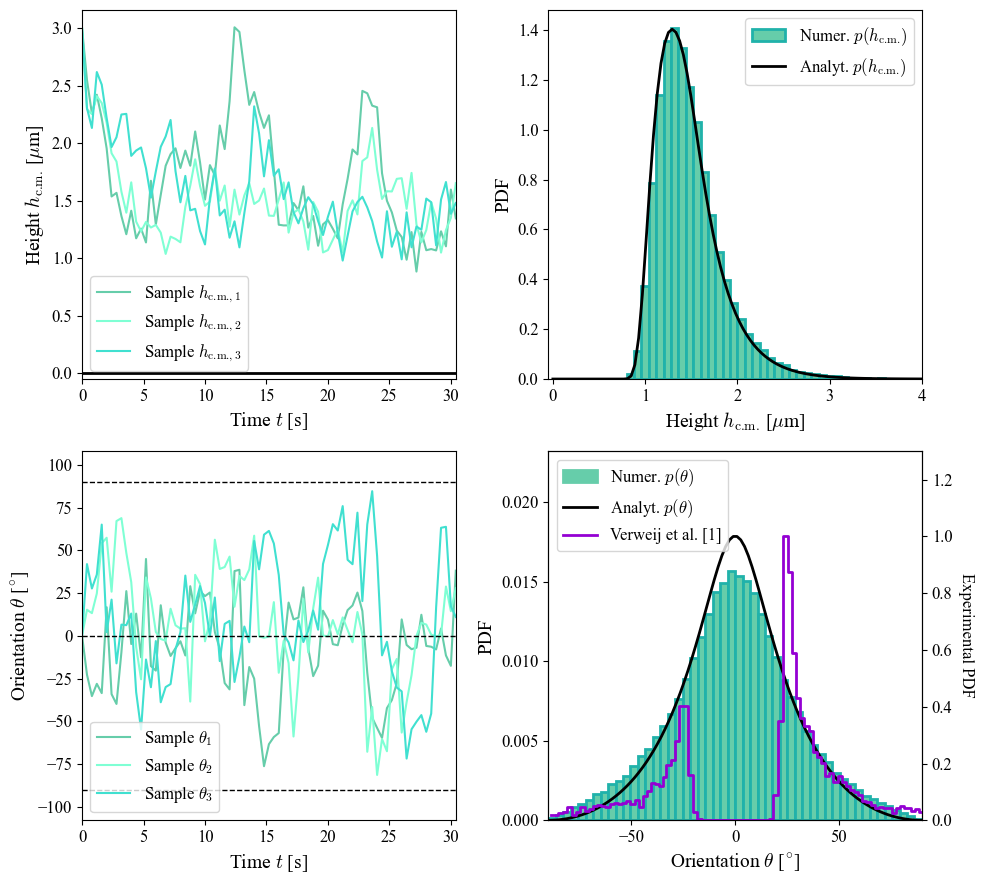

In [40]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(2, 2, figsize = (10,9))

###########

ax[0,0].plot(jnp.insert(t_n, 0, 0.0), 
	jnp.insert(1E6 * trajectories["solution_values"][9, :, 2], 0, 3.0),
	color = 'mediumaquamarine',
    label = 'Sample $h_{\\text{c.m.},1}$')
ax[0,0].plot(jnp.insert(t_n, 0, 0.0), 
	jnp.insert(1E6 * trajectories["solution_values"][6, :, 2], 0, 3.0),
	color = 'aquamarine',
    label = 'Sample $h_{\\text{c.m.},2}$')
ax[0,0].plot(jnp.insert(t_n, 0, 0.0), 
	jnp.insert(1E6 * trajectories["solution_values"][3, :, 2], 0, 3.0),
	color = 'turquoise',
    label = 'Sample $h_{\\text{c.m.},3}$')

ax[0,0].hlines(0, 0, t_n[-1], linewidth=2, color="k")

ax[0,0].set_xlabel("Time $t$ [s]", fontsize = 14)
ax[0,0].set_xlim(0, trajectories["time_values"][0, -1])
ax[0,0].set_ylim(bottom = -0.05)
ax[0,0].set_ylabel("Height $h_{\\text{c.m.}}$ [$\mu$m]", fontsize = 14)

ax[0,0].legend()

###########

ax[1,0].plot(jnp.insert(t_n, 0, 0.0), 
	jnp.insert(sample_theta_1, 0, 0.0),
	color = 'mediumaquamarine',
    label = 'Sample $\\theta_1$')
ax[1,0].plot(jnp.insert(t_n, 0, 0.0), 
	jnp.insert(sample_theta_2, 0, 0.0),
	color = 'aquamarine',
    label = 'Sample $\\theta_2$')
ax[1,0].plot(jnp.insert(t_n, 0, 0.0), 
	jnp.insert(sample_theta_3, 0, 0.0),
	color = 'turquoise',
    label = 'Sample $\\theta_3$')

ax[1,0].hlines([-90.0, 0, 90.0], 0, t_n[-1], linewidth=1, color="k", linestyle = 'dashed')

ax[1,0].set_xlabel("Time $t$ [s]", fontsize = 14)
ax[1,0].set_xlim(0, trajectories["time_values"][0, -1])
ax[1,0].set_ylabel("Orientation $\\theta$ [$^{\circ}$]", fontsize = 14)
ax[1,0].set_ylim(-1.2 * 90.0, 1.2 * 90.0)

ax[1,0].legend(loc = 'lower left')

###########

ax[0,1].hist(last_timestep['heights'], bins = 50, range = (0.0, 4.0), density = True,
	color = 'mediumaquamarine', edgecolor = 'lightseagreen',
	linewidth = 2.0, label = 'Numer. $p(h_{\\text{c.m.}})$')
ax[0,1].set_xlabel("Height $h_{\\text{c.m.}}$ [$\mu$m]", fontsize = 14)
ax[0,1].set_ylabel("PDF", fontsize = 14)

h_area = np.trapezoid(h_theor, 1e6 * h_range)
ax[0,1].plot(1e6 * h_range, h_theor / h_area, 'k',
	label = 'Analyt. $p(h_{\\text{c.m.}})$', linewidth = 2.0)
ax[0,1].set_xlim(-0.05, 4.0)
ax[0,1].set_ylim(bottom = 0.0)

ax[0,1].legend()

###########

df = pd.read_csv('small_dumbbells_scrapped.csv', header = 0)

ax[1,1].hist(last_timestep['thetas'], bins = 50, range = (-90.0, 90.0), density = True,
	color = 'mediumaquamarine', edgecolor = 'lightseagreen',
	linewidth = 2.0, label = 'Numer. $p(\\theta)$')

theta_area = np.trapezoid(theta_theor, theta_range)
lns1 = ax[1,1].plot(theta_range, theta_theor / theta_area, 'k',
	label = 'Analyt. $p(\\theta)$', linewidth = 2.0)

ax[1,1].set_xlabel("Orientation $\\theta$ [$^{\circ}$]", fontsize = 14)
ax[1,1].set_ylabel("PDF", fontsize = 14)

ax2 = ax[1,1].twinx()
lns2 = ax2.step(df['theta'], df['y'] / max(df['y']), where = 'mid', color = 'darkviolet', linewidth = 2.0,
    label = 'Verweij et al. [1]')

ax2.set_xlim(-90.0, 90.0)
ax2.set_ylim(bottom = 0.0, top = 1.3)

ax2.set_ylabel('Experimental PDF', rotation=270, va='bottom')

lns = lns1 + lns2

rectangle = Rectangle((0,0), 1, 1, color = 'mediumaquamarine', edgecolor = 'lightseagreen',
                      linewidth = 2.0,label='Numer. $p(\\theta)$')
lns.insert(0, rectangle)

ax[1,1].set_xlim(-90.0, 90.0)
ax[1,1].set_ylim(bottom = 0.0, top = max(theta_theor / theta_area) * 1.3)

ax[1,1].legend(handles=lns, loc = 'upper left')

plt.tight_layout()

plt.savefig('small_dumbbells_simulation.svg', dpi = 1200)